# HW 8
## James Camacho

We want to solve the following BVP with a Chebyshev spectral collocation method:
$$\epsilon\cdot\frac{d^2u(x)}{dx^2} + u(x)\left(\frac{du(x)}{dx}-1\right) = 0, u(a) = \alpha, u(b) = \beta.$$

### Finite Difference Method
We take the extrema of the $n$th Chebyshev polynomial, $T_n(\cos(\theta)) = \cos(n\theta)$, which are
$$x = \cos\left(\frac{k\pi}{n}\right), 0\le k\le n.$$

Then we just plug and chug into our finite difference solver.

In [659]:
import numpy as np
from scipy.special import factorial
from scipy.optimize import fsolve

def get_c(k, d=2):
    """
    k - An array with distances from the center point for the finite difference approximation.
    d - The order of the derivatives (i.e. 2 => u'').
    """
    n = len(k)
    M = np.zeros((n, n))
    for i in range(n):
        M[i] = np.power(k, i)
    
    D = np.zeros(n)
    D[d] = factorial(d)
    
    return np.linalg.solve(M, D)

def prepare_di(mesh):
    ds = []
    for d in range(3):
        rows = []
        for x in mesh:
            k = [m - x for m in mesh]
            rows.append(get_c(k, d=d))
        ds.append(rows)
        
    def di(i, u, d=2):
        return u @ ds[d][i]
    
    return di

def G(u, eps, alpha, beta, di):
    n = len(u)
    u[0] = alpha
    u[-1] = beta
    g = np.zeros(n)
    for i in range(1, n-1):
        g[i] = eps * di(i, u, d=2) + u[i] * (di(i, u, d=1) - 1)
    return g

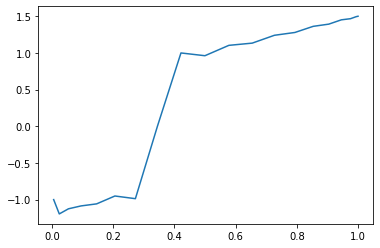

In [660]:
import matplotlib.pyplot as plt

a = 0
b = 1
alpha = -1
beta = 3/2
eps = 1e-2

n = 20
k = np.arange(n)
x = np.cos(k*np.pi/n)
x = np.sort(x)

# Maps domain from [-1, 1] to [a, b]
x = x*(b-a)/2 + (a+b)/2

# Line from (a, alpha) to (b, beta)
u = (beta - alpha) / (b-a) * (x-a) + alpha

di = prepare_di(x)
u = fsolve(G, u, args=(eps, alpha, beta, di))

plt.plot(x, u)
plt.show();

### Galerkin Method

We use the basis functions $(T_i)_{0\le i\le n}$, defined as

$$T_i(\cos\theta) = \cos(i\theta).$$

One useful property is these are orthogonal under the weighted norm

$$\langle T_i, T_j\rangle = \int_{-1}^{1}T_iT_j \frac{1}{\sqrt{1-x^2}}\text{d}x$$

which is easy to show with a change of variables:

$$
\begin{align*}
\int_{-1}^{1}T_i(x)T_j(x)\frac{1}{\sqrt{1-x^2}}\text{d}x &= \int_{0}^{\pi}\cos(i\theta)\cos(j\theta)\text{d}\theta\\
&= \frac12\int_0^\pi \cos((i+j)\theta) + \cos((i-j)\theta) \text{d}\theta\\
&=\begin{cases}0&i\ne j\\\pi/2&i=j.\end{cases}
\end{align*}
$$

---

We approximate $u$ with the function

$$v := \sum_{i=0}^n c_iT_i$$

and we want $v$ to exactly solve the BVP on our collocation points. We choose the extrema of the $n$th Chebyshev polynomial as the collocation points:

$$x = \cos\left(\frac{k\pi}{n}\right), 0\le k \le n$$

We will need to calculate $T_i'$ and $T_i''$. It's best to use a recursive strategy, as

$$T_{i} = 2xT_{i-1} - T_{i-2}$$

which means

$$T_{i}' = 2T_{i-1} + 2xT_{i-1}' - T_{i-2}',$$
$$T_{i}'' = 4T_{i-1}' + 2xT_{i-1}'' - T_{i-2}''.$$

Typically you have some linear domain mapping as well. In that case,

$$\frac{dT(\phi(x))}{dx} = T'\phi',$$

$$\frac{d^2T(\phi(x))}{dx^2} = T''\phi' + T'\phi'' = T''\phi'$$

as $\phi$ is linear, so $\phi''=0$.

In [661]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

def cheby_poly(c, x, domain=[-1, 1]):
    """
    Evaluates a chebyshev polynomial with coefficients c at x.
    """
    a, b = domain
    # Map from domain to [-1, 1]
    x = x * 2/(b-a) + (a+b)/(a-b)
    T = [np.ones_like(x), x]
    for i in range(n-1):
        T.append(2*x*T[-1] - T[-2])
    
    T = np.array(T).T
    return T @ c

def cheby_eval(x, n, domain=[-1, 1]):
    """
    Evaluates the chebyshev polynomial at x, as well as their first and second derivative.
    """
    
    a, b = domain
    # Map from domain to [-1, 1]
    x = x * 2/(b-a) + (a+b)/(a-b)
    
    # Derivative of map
    dphi = 2/(b-a)
    
    T = [np.ones_like(x), x]
    Tp = [np.zeros_like(x), np.ones_like(x)]
    Tpp = [np.zeros_like(x), np.zeros_like(x)]
    for i in range(n-1):
        Tpp.append(4*Tp[-1] + 2*x*Tpp[-1] - Tpp[-2])
        Tp.append(2*T[-1] + 2*x*Tp[-1] - Tp[-2])
        T.append(2*x*T[-1] - T[-2])
        
    T = np.array(T).T
    Tp = np.array(Tp).T
    Tpp = np.array(Tpp).T
    return T, dphi*Tp, dphi*Tpp

def G(c, eps, d0, d1, d2):
    u = d0 @ c
    du = d1 @ c
    ddu = d2 @ c
    g = eps * ddu + u*(du - 1)
    g[0] = u[0] - alpha
    g[-1] = u[-1] - beta
    return g

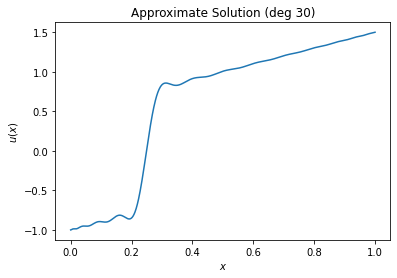

In [662]:
a = 0
b = 1
alpha = -1
beta = 3/2
eps = 1e-2

n = 1

# Initially a line from (a, alpha) to (b, beta)
c = np.zeros(n+1)
c[0] =  alpha - a/(b-a)*(beta-alpha)
c[1] = (beta - alpha) / (b - a)

# Slowly increase n
while n < 30:
    n += 1
    c = np.concatenate([c, [0]])
    
    # Chebyshev Roots
    k = np.arange(n+1)
    x = np.cos(k*np.pi/n)

    # Map from [-1, 1] to [a, b]
    x = x*(b-a)/2 +(a+b)/2
    x = np.sort(x) # So we know where the boundaries are.

    coeffs = cheby_eval(x, n, domain=[a,b])

    # Slowly decrease eps (continuation)
    e = 1
    while e > eps:
        c = fsolve(G, c, args=(e, *coeffs))
        e *= 0.5
        if e < eps:
            e = eps
            
xi = np.linspace(a, b, 1000)
plt.title(f"Approximate Solution (deg {n})")
plt.plot(xi, cheby_poly(c, xi, domain=[a,b]))
plt.xlabel("$x$")
plt.ylabel("$u(x)$")
plt.show();